# ITTI step by step

## image process

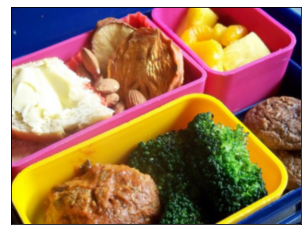

In [31]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    try:
        if img.shape[2]==3:
            pic = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            plt.imshow(pic, interpolation = 'bicubic')
    except:
        plt.imshow(img)
    plt.xticks([]), plt.yticks([]) # 隐藏 X 和 Y 轴的刻度值
def matrix_imshow(imgs):
    ''''
    imgs必须是一个2d矩阵, 矩阵每个元素是一张图
    '''
    for i in range(imgs.shape[0]):
        for j in range(imgs.shape[1]):
            plt.subplot(imgs.shape[0],imgs.shape[1],i+1)
            imshow(imgs[i,j])
def list_imshow(imgs):
    '''
    imgs是一个list
    '''
    for i in range(len(imgs)):
        plt.subplot(1, len(imgs),i+1)
        imshow(imgs[i])

img = cv.imread('test_images/1.jpg')
imshow(img)


## 构建高斯金字塔

In [32]:
class GaussianPyramid:
    '''
    高斯金字塔
    '''
    def __init__(self, src):
        self.maps = self.make_gaussian_pyramid(src)  # 生成高斯金字塔

    def make_gaussian_pyramid(self, src):
        '''
        高斯金字塔，输出一系列特征图
        '''
        img = src.copy()
        maps = {'intensity': [],
                'colors': {'b': [], 'g': [], 'r': [], 'y': []},
                'orientations': {'0': [], '45': [], '90': [], '135': []}}
        max = np.max(img)  # 最大值
        for x in range(1, 9):
            img = cv.pyrDown(img) # 构建高斯金字塔，先高斯平滑后降采样到上一张图的一半
            if x < 2: # c \in {2,3,4}
                continue
            its_map = self.get_intensity_map(img)
            B , G, R, Y = self.get_color_map(img, its_map, max)

            maps['intensity'].append(its_map)

            maps['colors']['b'].append(B)
            maps['colors']['g'].append(G)
            maps['colors']['r'].append(R)
            maps['colors']['y'].append(Y)

            maps['orientations']['0'].append(self.get_orientation_map(its_map , 0))
            maps['orientations']['45'].append(self.get_orientation_map(its_map , np.pi/4))
            maps['orientations']['90'].append(self.get_orientation_map(its_map , np.pi/2))
            maps['orientations']['135'].append(self.get_orientation_map(its_map , np.pi*3/4))

        return maps

    def get_intensity_map(self, img):
        '''
        获取亮度
        '''
        return np.mean(img,axis=2)

    def get_color_map(self, img, its_map , max):
        '''
        构建r,g,b,y四种颜色的高斯金字塔
        '''
        img = np.where(img<0.1*max, 0, img)# 将小于最大值的十分之一的数据置零
        b, g, r = cv.split(img)
        R = r - (g + b)/2
        G = g - (r + b)/2
        B = b - (r + g)/2
        Y = (r + g)/2 - np.abs(r - g)/2 -b
        color_map = cv.merge([B, G, R, Y])
        its_map_ = np.stack([its_map for _ in range(4)], axis = 2)
        
        color_map = np.where(its_map_>0.1*max, color_map/its_map_, 0)# 对亮度做正则化
        color_map = np.where(color_map>0, color_map, 0)# 将负数都置为0
        return cv.split(color_map)

    def get_orientation_map(self, its_map, theta):
        '''
        一个二维的Gabor滤波器是一个正弦平面波和高斯核函数的乘积
        其频率和方向表达与人类视觉系统类似，能够提供良好的方向选择和尺度选择特性
        '''
        kernel = cv.getGaborKernel((8, 8), 4, theta, 8, 1)
        return cv.filter2D(its_map, cv.CV_32F, kernel)

In [33]:
gaussian = GaussianPyramid(img)

/tmp/ipykernel_319449/2461191986.py:57: RuntimeWarning: invalid value encountered in true_divide
  color_map = np.where(its_map_>0.1*max, color_map/its_map_, 0)# 对亮度做正则化


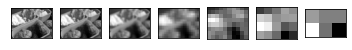

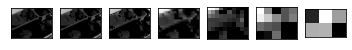

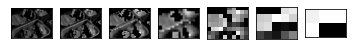

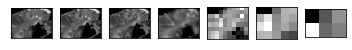

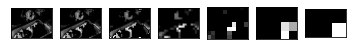

In [34]:
list_imshow(gaussian.maps['intensity'])
plt.figure()
list_imshow(gaussian.maps['colors']['b'])
plt.figure()
list_imshow(gaussian.maps['colors']['g'])
plt.figure()
list_imshow(gaussian.maps['colors']['r'])
plt.figure()
list_imshow(gaussian.maps['colors']['y'])


## 构建差分特征图

In [35]:
class FeatureMap:
    '''
    获取差分特征图
    '''
    def __init__(self,src):
        self.maps = self.make_feature_map(src)

    def make_feature_map(self, src):
        cs_index = ((0, 3), (0, 4), (1, 4), (1, 5), (2, 5), (2, 6))  # 用来计算center-surround的index值（不同的层代表着中心或者周边）
        maps = {'intensity': [],
                'colors': {'rg': [], 'by': []},
                'orientations': {'0': [], '45': [], '90': [], '135': []}}
        for c, s in cs_index:
            maps['intensity'].append(self.scale_diff(src['intensity'][c], src['intensity'][s]))

            for key in maps['colors'].keys():
                maps['colors'][key].append(self.scale_diff(
                    src['colors'][key[0]][c] - src['colors'][key[1]][c],
                    src['colors'][key[1]][s] - src['colors'][key[0]][s]
                ))

            for key in maps['orientations'].keys():
                maps['orientations'][key].append(self.scale_diff(src['orientations'][key][c], src['orientations'][key][s]))  # 差分操作
        return maps

    def scale_diff(self, c, s):
        '''
        差分操作
        '''
        c_size = (c.shape[1], c.shape[0])
        return cv.absdiff(c, cv.resize(s, c_size, None, 0, 0, cv.INTER_NEAREST))

In [36]:
features = FeatureMap(gaussian.maps)

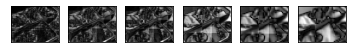

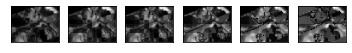

In [37]:
list_imshow(features.maps['intensity'])
plt.figure()
list_imshow(features.maps['colors']['rg'])

In [38]:
def normalize(src):
    # 0,1归一化
    min = np.min(src)
    max = np.max(src)
    src = (src - min)/(max - min)

    # 找局部最大值
    local_maxs = []
    for y in range(1, len(src) - 1):
        for x in range(1, len(src[0]) - 1):
            val = src[y][x]
            if val > src[y - 1][x] and val > src[y + 1][x] and val > src[y][x - 1] and val > src[y][x + 1]:
                # 当前点亮度大于上下左右
                local_maxs.append(val)

    mean_maxs = np.sum(local_maxs) / np.float64(len(local_maxs)) # 计算局部最大值的均值

    src *= (1 - mean_maxs)**2
    return src

## 得到三个显著图

In [39]:
class ConspicuityMap:
    # 显著图
    def __init__(self, src):
        self.maps = self.make_conspicuity_map(src)

    def make_conspicuity_map(self, src):
        '''
        多尺度融合归一化，得到三个显著图
        '''
        intensity = self.scale_add(list(map(normalize, src['intensity'])))  # 亮度累加
        
        for key in src['colors'].keys():
            src['colors'][key] = list(map(normalize, src['colors'][key]))
        color = self.scale_add([src['colors']['rg'][x] + src['colors']['by'][x] for x in range(len(src['colors']['rg']))])  # 颜色累加
        
        tmp = []
        for key in src['orientations'].keys():# 同一方向的方向图做尺度融合
            tmp.append( self.scale_add(list(map(normalize, src['orientations'][key]))) ) 
        orientation = np.zeros(intensity.shape)
        for _ in tmp:# 把所有方向的方向图归一化后加起来
            orientation += normalize(_)
        
        return {'intensity': intensity, 'color': color, 'orientation': orientation}  #三个属性下的显著图

    def scale_add(self, src):
        '''
        同一个属性差分特征图进行累加
        '''
        buf = np.zeros(src[0].shape)
        for x in src:
            buf += cv.resize(x, (buf.shape[1],buf.shape[0]))
        return buf

In [40]:
conspicuity = ConspicuityMap(features.maps)

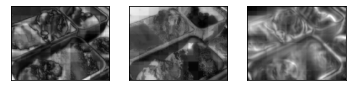

In [41]:
list_imshow(list(conspicuity.maps.values()))

## 融合显著图

In [42]:
class SaliencyMap:
    '''
    融合显著图
    '''
    def __init__(self, src):
        self.gp = GaussianPyramid(src)
        self.fm = FeatureMap(self.gp.maps)
        self.cm = ConspicuityMap(self.fm.maps)
        self.map = cv.resize(self.make_saliency_map(self.cm.maps), tuple(reversed(src.shape[0:2])))

    def make_saliency_map(self, src):
        '''
        得到融合显著图
        '''
        src = list(map(normalize, [src[key] for key in src.keys()]))
        # 将各个属性下的显著图等比例相加
        return (src[0] + src[1] + src[2]) / 3

In [43]:
saliency = SaliencyMap(img)

/tmp/ipykernel_319449/2461191986.py:57: RuntimeWarning: invalid value encountered in true_divide
  color_map = np.where(its_map_>0.1*max, color_map/its_map_, 0)# 对亮度做正则化


## 最终效果

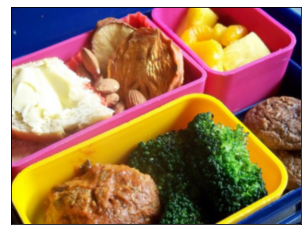

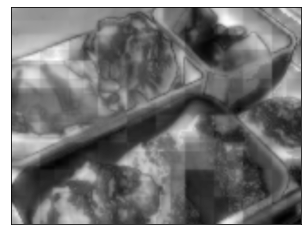

In [44]:
imshow(img)
plt.figure()
imshow(saliency.map)
plt.set_cmap('gray')